# Feature Selection Experiments for openSMILE

The [openSMILE Python API](https://audeering.github.io/opensmile-python/) includes the [ComParE 2016](http://www.tangsoo.de/documents/Publications/Schuller16-TI2.pdf) feature set which enables us to extract 65 low-level descriptors (for ex. MFCC) as well as 6373 Functionals derived from these decriptors. 

For each audio file - the LLDs are a `samples x 65` df and the functionals are a `1 x 6373` df. 

In these experiments, we extract the functionals for both real and fake audio data and run a set of feature selection techniques to identify a handful subset of features for use in a final predictive model.

# Import Statements

In [1]:
import opensmile 
import pandas as pd
import numpy as np
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel, SelectKBest, mutual_info_regression, SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, confusion_matrix, classification_report
import random
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from sklearn import svm
from pprint import pprint
from tqdm import tqdm
base_path = "/home/ubuntu/"

# Experimental Data

To save time, the data is sampled and features are extracted using openSMILE in a separate notebook `sampling_and_mixing_data.ipynb` and saved in `.csv` format for reusability. The dataset used contains original audio from the [LJSpeech 1.1](https://keithito.com/LJ-Speech-Dataset/) dataset and fake audio generated using GANs from the [NeurIPS 2021 WaveFake](https://arxiv.org/abs/2111.02813) dataset. It also contains audio from LJSpeech generated using ElevenLabs.

Contains 12,800 audio files - 6400 each real and fake with a set of 800 real audio files matching a set of the same 800 fakes generated using one of the archs listed below. 

## Loading and Summary

In [2]:
exp_data_file = '/home/ubuntu/testing-code/opensmile-feature-importance/smile_dfs/0310-lj_experimental_data_v1.csv'
exp_data_df = pd.read_csv(exp_data_file)

In [3]:
exp_data_df.head()

,id,file,type,fake,duration(seconds),audspec_lengthL1norm_sma_range,audspec_lengthL1norm_sma_maxPos,audspec_lengthL1norm_sma_minPos,audspec_lengthL1norm_sma_quartile1,audspec_lengthL1norm_sma_quartile2,...,mfcc_sma_de[14]_peakRangeAbs,mfcc_sma_de[14]_peakRangeRel,mfcc_sma_de[14]_peakMeanAbs,mfcc_sma_de[14]_peakMeanMeanDist,mfcc_sma_de[14]_peakMeanRel,mfcc_sma_de[14]_minRangeRel,mfcc_sma_de[14]_meanRisingSlope,mfcc_sma_de[14]_stddevRisingSlope,mfcc_sma_de[14]_meanFallingSlope,mfcc_sma_de[14]_stddevFallingSlope
0,LJ032-0137,/home/ubuntu/data/wavefake_data/LJSpeech_1.1/w...,ElevenLabs,0,7.762,2.529597,0.608866,0.765319,0.343702,0.589645,...,10.773912,0.657822,2.936347,2.935397,20.000000,0.609994,129.240130,64.158455,130.97571,60.847908
1,LJ038-0165,/home/ubuntu/data/wavefake_data/LJSpeech_1.1/w...,ElevenLabs,0,8.656,2.406416,0.005841,0.695093,0.295922,0.514596,...,8.458103,0.531263,2.910538,2.911863,-20.000000,0.650057,125.028530,58.838596,115.42761,55.276188
2,LJ044-0203,/home/ubuntu/data/wavefake_data/LJSpeech_1.1/w...,ElevenLabs,0,5.150,2.695161,0.249012,0.175889,0.375376,0.674925,...,11.555664,0.663116,2.731076,2.731820,-20.000000,0.479881,126.260170,54.306473,109.07703,62.240750
3,LJ003-0044,/home/ubuntu/data/wavefake_data/LJSpeech_1.1/w...,ElevenLabs,0,3.199,2.287197,0.528846,0.996795,0.478625,0.801715,...,11.162925,0.497092,3.827386,3.820832,19.997963,0.526514,155.382830,77.223274,146.11166,88.627940
4,LJ036-0116,/home/ubuntu/data/wavefake_data/LJSpeech_1.1/w...,ElevenLabs,0,2.340,2.027513,0.181416,0.513274,0.277241,0.572403,...,6.160469,0.462080,2.797420,2.774368,19.579084,0.638266,99.164055,44.689617,123.44574,49.456890


In [4]:
exp_data_df.shape

(12800, 6378)

In [5]:
exp_data_df.type.value_counts()

ElevenLabs           1600
Waveglow             1600
Parallel_WaveGan     1600
Multi_Band_MelGan    1600
MelGanLarge          1600
MelGan               1600
HifiGan              1600
Full_Band_MelGan     1600
Name: type, dtype: int64

In [6]:
#check to ensure each id has a corresponding fake
exp_data_df.id.value_counts()

LJ032-0137    2
LJ038-0118    2
LJ046-0168    2
LJ016-0171    2
LJ037-0020    2
             ..
LJ004-0171    2
LJ042-0184    2
LJ015-0150    2
LJ007-0172    2
LJ028-0069    2
Name: id, Length: 6400, dtype: int64

## Train-Dev-Test Split:

In [7]:
#split data based on unique id which has a real fake pair after shuffling
id_list = exp_data_df.id.unique()
np.random.shuffle(id_list)

In [8]:
#split the data 
f1 = 0.8
f2 = 0.9
train_ids, dev_ids, test_ids = np.split(id_list, [int(f1*len(id_list)), int(f2*len(id_list))])

In [9]:
#check split
len(train_ids), len(dev_ids), len(test_ids), (len(train_ids) + len(dev_ids) + len(test_ids))

(5120, 640, 640, 6400)

In [10]:
train_df = exp_data_df[exp_data_df.id.isin(train_ids)].sample(frac=1).reset_index(drop=True)
dev_df = exp_data_df[exp_data_df.id.isin(dev_ids)].sample(frac=1).reset_index(drop=True)
test_df = exp_data_df[exp_data_df.id.isin(test_ids)].sample(frac=1).reset_index(drop=True)

In [11]:
train_df.type.value_counts()

MelGanLarge          1308
Multi_Band_MelGan    1306
HifiGan              1296
ElevenLabs           1280
Full_Band_MelGan     1280
Waveglow             1272
Parallel_WaveGan     1260
MelGan               1238
Name: type, dtype: int64

In [12]:
dev_df.type.value_counts()

Waveglow             180
Parallel_WaveGan     170
MelGan               166
HifiGan              164
MelGanLarge          158
Full_Band_MelGan     150
ElevenLabs           146
Multi_Band_MelGan    146
Name: type, dtype: int64

In [13]:
test_df.type.value_counts()

MelGan               196
ElevenLabs           174
Parallel_WaveGan     170
Full_Band_MelGan     170
Multi_Band_MelGan    148
Waveglow             148
HifiGan              140
MelGanLarge          134
Name: type, dtype: int64

__Feature Scaling:__

In [14]:
exp_data_scaler = StandardScaler()
train_df.iloc[:,5:] = exp_data_scaler.fit_transform(train_df.iloc[:,5:])
dev_df.iloc[:,5:] = exp_data_scaler.transform(dev_df.iloc[:,5:])
test_df.iloc[:,5:] = exp_data_scaler.transform(test_df.iloc[:,5:])

In [15]:
X_train = train_df.drop(columns=['id', 'file', 'type', 'duration(seconds)', 'fake']).copy()
y_train = train_df['fake'].copy()

X_dev = dev_df.drop(columns=['id', 'file', 'type', 'duration(seconds)', 'fake'])
y_dev = dev_df['fake'].copy()

X_train_final = pd.concat([X_train, X_dev])
y_train_final = pd.concat([y_train, y_dev])

X_test = test_df.drop(columns=['id', 'file', 'type', 'duration(seconds)', 'fake'])
y_test = test_df['fake'].copy()

# Utility Functions for running models

In [16]:
def generate_confusion_matrix(y_test, yhat_test):
    
    #generate confusion matrix
    cm = confusion_matrix(y_test, yhat_test)

    #plot confusion matrix
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia_r)
    classNames = ['Real','Fake']
    plt.title('Real vs Fake Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
    plt.show()

In [17]:
def generate_ROC_curve(model, y_test, X_test):
    
    # generate a no skill prediction (majority class)
    ns_probs = [0 for _ in range(len(y_test))]
    # predict probabilities
    lr_probs = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    # calculate scores
    ns_auc = roc_auc_score(y_test, ns_probs)
    lr_auc = roc_auc_score(y_test, lr_probs)
    # summarize scores
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Logistic: ROC AUC=%.3f\n' % (lr_auc))
    
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
    # plot the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

In [18]:
def run_model_on_test_data(model_m, X_train_m, X_test_m, y_train_m, y_test_m, feature_index_m):
    
    #fit model
    model_m.fit(X_train_m[feature_index], y_train_m)
    
    #predict on held out test data
    yhat_train_m = model_m.predict(X_train_m[feature_index])
    yhat_test_m = model_m.predict(X_test_m[feature_index])
    
    #compute accuracy 
    accuracy_train = accuracy_score(y_train_m, yhat_train_m)
    accuracy_test = accuracy_score(y_test_m, yhat_test_m)
    
    #print
    print('<---- Train and Test Accuracy ---->\n')
    print('Logistic accuracy train = %.3f' % (accuracy_train*100))
    print('Logistic accuracy test = %.3f' % (accuracy_test*100))
    
    print('\n<---- Classification Report ---->\n')
    print(classification_report(y_test_m, yhat_test_m))
    
    print('\n<---- Confusion Matrix ---->\n')
    generate_confusion_matrix(y_test_m, yhat_test_m)
    
    print('\n<---- ROC-AUC ---->\n')
    generate_ROC_curve(model_m, y_test_m, X_test_m[feature_index_m])

# Experiment 1: Brute Force Feature Selection

In the first experiment, we break down the data set into each architecture used to generate fakes 

## Brute Force Selection

In [19]:
def run_bflr_for_arch(train_df, dev_df, arch, all_archs=False):
    
    #prepare data
    if all_archs==False:
        trdf = train_df[train_df.type==arch]
    if all_archs==True:
        trdf = train_df[train_df.type.isin(arch)]
    
    if all_archs==False:
        dvdf = dev_df[dev_df.type==arch]
    if all_archs==True:
        dvdf = dev_df[dev_df.type.isin(arch)]
    
    X_train = trdf.drop(columns=['id', 'file', 'type', 'duration(seconds)', 'fake']).copy()
    y_train = trdf['fake'].copy()
    
    X_dev = dvdf.drop(columns=['id', 'file', 'type', 'duration(seconds)', 'fake']).copy()
    y_dev = dvdf['fake'].copy()
    
    train_accuracies = []
    dev_accuracies = []
    
    for i in tqdm(range(6373)):
        
        model_lr = LogisticRegression()
        model_lr.fit(X_train.iloc[:,i].to_numpy().reshape(-1, 1), y_train)
        y_hat_train = model_lr.predict(X_train.iloc[:,i].to_numpy().reshape(-1, 1))
        y_hat_dev = model_lr.predict(X_dev.iloc[:,i].to_numpy().reshape(-1, 1))
        train_accuracy = accuracy_score(y_train, y_hat_train)
        train_accuracies.append(train_accuracy)        
        dev_accuracy = accuracy_score(y_dev, y_hat_dev)
        dev_accuracies.append(dev_accuracy)
    
    print("\nAverage train accuracy: {}".format(np.mean(train_accuracies)))
    print("Average dev accuracy: {}\n".format(np.mean(dev_accuracies)))
    
    return dev_accuracies

In [90]:
archs = list(exp_data_df.type.unique())
features = train_df.columns.to_list()[5:]
bruteforce_df = pd.DataFrame(features, columns=['features'])

for arch in archs:
    print("\nRunning for {} architecture\n".format(arch))
    bruteforce_df[arch] = run_bflr_for_arch(train_df, dev_df, arch)

print("\nRunning for all architectures\n")
bruteforce_df['all_archs'] = run_bflr_for_arch(train_df, dev_df, archs, all_archs=True)


Running for ElevenLabs architecture



100%|██████████| 6373/6373 [00:13<00:00, 483.46it/s]



Average train accuracy: 0.6237144251137612
Average dev accuracy: 0.6245203974816703


Running for Waveglow architecture



100%|██████████| 6373/6373 [00:11<00:00, 533.33it/s]



Average train accuracy: 0.5289051097051535
Average dev accuracy: 0.5273942151786181


Running for Parallel_WaveGan architecture



100%|██████████| 6373/6373 [00:11<00:00, 532.71it/s]



Average train accuracy: 0.5283742923394579
Average dev accuracy: 0.5274762093759519


Running for Multi_Band_MelGan architecture



100%|██████████| 6373/6373 [00:11<00:00, 537.58it/s]



Average train accuracy: 0.5241579558094555
Average dev accuracy: 0.5247877926784443


Running for MelGanLarge architecture



100%|██████████| 6373/6373 [00:11<00:00, 537.48it/s]



Average train accuracy: 0.5271879982974811
Average dev accuracy: 0.5251943027050432


Running for MelGan architecture



100%|██████████| 6373/6373 [00:11<00:00, 541.24it/s]



Average train accuracy: 0.5226313199845775
Average dev accuracy: 0.5227701957996745


Running for HifiGan architecture



100%|██████████| 6373/6373 [00:11<00:00, 536.64it/s]



Average train accuracy: 0.5157527028571539
Average dev accuracy: 0.5147009296077584


Running for Full_Band_MelGan architecture



100%|██████████| 6373/6373 [00:11<00:00, 542.52it/s]



Average train accuracy: 0.5128150498195513
Average dev accuracy: 0.5098090904336001


Running for all architectures



100%|██████████| 6373/6373 [00:25<00:00, 245.60it/s]


Average train accuracy: 0.5172034057253255
Average dev accuracy: 0.5168903479522987



#### Analysis Tables and Feature Selection

In [21]:
bruteforce_df[(bruteforce_df.iloc[:,1] > 0.95)].sort_values(by='ElevenLabs', ascending=False)

,features,ElevenLabs,Waveglow,Parallel_WaveGan,Multi_Band_MelGan,MelGanLarge,MelGan,HifiGan,Full_Band_MelGan,all_archs
93,pcm_zcr_sma_range,0.993151,0.533333,0.564706,0.541096,0.531646,0.493976,0.512195,0.533333,0.551562
217,pcm_zcr_sma_de_range,0.993151,0.561111,0.552941,0.589041,0.550633,0.506024,0.530488,0.486667,0.549219
96,pcm_zcr_sma_quartile1,0.993151,0.516667,0.558824,0.609589,0.518987,0.518072,0.506098,0.566667,0.530469
228,pcm_zcr_sma_de_pctlrange0-1,0.993151,0.544444,0.494118,0.547945,0.550633,0.487952,0.512195,0.513333,0.550781
227,pcm_zcr_sma_de_percentile99.0,0.993151,0.522222,0.511765,0.541096,0.537975,0.487952,0.512195,0.513333,0.540625
226,pcm_zcr_sma_de_percentile1.0,0.993151,0.511111,0.529412,0.527397,0.556962,0.500000,0.524390,0.480000,0.550000
105,pcm_zcr_sma_stddev,0.993151,0.550000,0.488235,0.527397,0.518987,0.493976,0.493902,0.506667,0.530469
4202,pcm_zcr_sma_rqmean,0.986301,0.538889,0.505882,0.506849,0.531646,0.493976,0.512195,0.493333,0.530469
104,pcm_zcr_sma_pctlrange0-1,0.986301,0.533333,0.541176,0.534247,0.531646,0.506024,0.493902,0.566667,0.550000
97,pcm_zcr_sma_quartile2,0.986301,0.538889,0.511765,0.623288,0.525316,0.506024,0.518293,0.500000,0.520312


In [88]:
bruteforce_df[(bruteforce_df.iloc[:,1:] > 0.95).any(axis=1)]

AttributeError: 'Styler' object has no attribute 'iloc'

In [89]:
bruteforce_df[(bruteforce_df.iloc[:,1:] > 0.55).all(1)]

AttributeError: 'Styler' object has no attribute 'iloc'

In [24]:
bruteforce_df[(bruteforce_df.iloc[:,1:] > 0.6).all(1)]

,features,ElevenLabs,Waveglow,Parallel_WaveGan,Multi_Band_MelGan,MelGanLarge,MelGan,HifiGan,Full_Band_MelGan,all_archs
3776,jitterDDP_sma_flatness,0.671233,0.738889,0.7,0.835616,0.696203,0.73494,0.713415,0.64,0.690625


In [25]:
bruteforce_df[(bruteforce_df.iloc[:,2:-1] > 0.55).all(axis=1)]

,features,ElevenLabs,Waveglow,Parallel_WaveGan,Multi_Band_MelGan,MelGanLarge,MelGan,HifiGan,Full_Band_MelGan,all_archs
1265,pcm_fftMag_spectralFlux_sma_lpgain,0.876712,0.583333,0.717647,0.678082,0.588608,0.602410,0.579268,0.573333,0.447656
1493,pcm_fftMag_spectralHarmonicity_sma_quartile3,0.842466,0.561111,0.694118,0.671233,0.594937,0.560241,0.585366,0.586667,0.555469
1495,pcm_fftMag_spectralHarmonicity_sma_iqr2-3,0.842466,0.577778,0.694118,0.657534,0.569620,0.572289,0.591463,0.566667,0.535156
1496,pcm_fftMag_spectralHarmonicity_sma_iqr1-3,0.835616,0.572222,0.682353,0.671233,0.588608,0.578313,0.573171,0.593333,0.556250
1854,mfcc_sma[11]_lpgain,0.616438,0.605556,0.629412,0.602740,0.829114,0.819277,0.554878,0.560000,0.583594
2945,pcm_fftMag_spectralFlux_sma_de_range,0.671233,0.566667,0.735294,0.589041,0.569620,0.602410,0.682927,0.580000,0.567969
2950,pcm_fftMag_spectralFlux_sma_de_quartile3,0.739726,0.555556,0.635294,0.575342,0.550633,0.560241,0.579268,0.560000,0.542969
2956,pcm_fftMag_spectralFlux_sma_de_pctlrange0-1,0.801370,0.572222,0.770588,0.623288,0.588608,0.632530,0.621951,0.566667,0.576562
2957,pcm_fftMag_spectralFlux_sma_de_stddev,0.842466,0.577778,0.764706,0.643836,0.582278,0.644578,0.628049,0.566667,0.588281
3591,mfcc_sma_de[12]_lpc0,0.671233,0.555556,0.600000,0.582192,0.898734,0.897590,0.554878,0.560000,0.542969


In [26]:
bruteforce_df[(bruteforce_df.iloc[:,2:-1] > 0.9).any(axis=1)]

,features,ElevenLabs,Waveglow,Parallel_WaveGan,Multi_Band_MelGan,MelGanLarge,MelGan,HifiGan,Full_Band_MelGan,all_archs
1701,mfcc_sma[6]_lpc1,0.753425,0.538889,0.535294,0.636986,0.898734,0.915663,0.573171,0.586667,0.638281
1732,mfcc_sma[7]_lpc1,0.780822,0.516667,0.541176,0.547945,0.854430,0.903614,0.548780,0.566667,0.636719
1762,mfcc_sma[8]_lpc0,0.801370,0.566667,0.617647,0.554795,0.911392,0.927711,0.542683,0.573333,0.620313
1763,mfcc_sma[8]_lpc1,0.616438,0.461111,0.405882,0.527397,0.911392,0.963855,0.567073,0.546667,0.626563
1794,mfcc_sma[9]_lpc1,0.602740,0.500000,0.552941,0.547945,0.886076,0.903614,0.542683,0.586667,0.587500
1824,mfcc_sma[10]_lpc0,0.767123,0.533333,0.500000,0.472603,0.911392,0.945783,0.500000,0.560000,0.599219
1825,mfcc_sma[10]_lpc1,0.589041,0.533333,0.494118,0.500000,0.898734,0.945783,0.567073,0.593333,0.608594
1855,mfcc_sma[11]_lpc0,0.808219,0.505556,0.629412,0.527397,0.886076,0.915663,0.530488,0.533333,0.588281
1856,mfcc_sma[11]_lpc1,0.623288,0.527778,0.576471,0.424658,0.905063,0.939759,0.603659,0.566667,0.615625
1887,mfcc_sma[12]_lpc1,0.636986,0.511111,0.517647,0.541096,0.892405,0.915663,0.573171,0.526667,0.592969


In [27]:
bruteforce_df[(bruteforce_df.iloc[:,-1] > 0.60)]

,features,ElevenLabs,Waveglow,Parallel_WaveGan,Multi_Band_MelGan,MelGanLarge,MelGan,HifiGan,Full_Band_MelGan,all_archs
66,pcm_RMSenergy_sma_quartile2,0.719178,0.533333,0.658824,0.636986,0.563291,0.578313,0.603659,0.560000,0.604688
67,pcm_RMSenergy_sma_quartile3,0.664384,0.561111,0.670588,0.678082,0.544304,0.536145,0.591463,0.540000,0.601562
1436,pcm_fftMag_spectralSlope_sma_percentile99.0,0.938356,0.544444,0.729412,0.575342,0.664557,0.596386,0.536585,0.593333,0.611719
1670,mfcc_sma[5]_lpc1,0.808219,0.527778,0.488235,0.582192,0.848101,0.855422,0.573171,0.480000,0.620313
1671,mfcc_sma[5]_lpc2,0.554795,0.583333,0.488235,0.705479,0.841772,0.825301,0.597561,0.573333,0.617969
1699,mfcc_sma[6]_lpgain,0.582192,0.566667,0.647059,0.465753,0.797468,0.789157,0.512195,0.506667,0.600781
1700,mfcc_sma[6]_lpc0,0.856164,0.544444,0.529412,0.431507,0.860759,0.837349,0.481707,0.520000,0.620313
1701,mfcc_sma[6]_lpc1,0.753425,0.538889,0.535294,0.636986,0.898734,0.915663,0.573171,0.586667,0.638281
1731,mfcc_sma[7]_lpc0,0.897260,0.527778,0.535294,0.527397,0.822785,0.873494,0.567073,0.453333,0.615625
1732,mfcc_sma[7]_lpc1,0.780822,0.516667,0.541176,0.547945,0.854430,0.903614,0.548780,0.566667,0.636719


In [28]:
max_idxs = []
for arch in archs + ['all_archs']:
    max_idxs.append(bruteforce_df[arch].idxmax())
bruteforce_df[bruteforce_df.index.isin(max_idxs)]

,features,ElevenLabs,Waveglow,Parallel_WaveGan,Multi_Band_MelGan,MelGanLarge,MelGan,HifiGan,Full_Band_MelGan,all_archs
93,pcm_zcr_sma_range,0.993151,0.533333,0.564706,0.541096,0.531646,0.493976,0.512195,0.533333,0.551562
1763,mfcc_sma[8]_lpc1,0.616438,0.461111,0.405882,0.527397,0.911392,0.963855,0.567073,0.546667,0.626563
3468,mfcc_sma_de[8]_lpc1,0.575342,0.533333,0.411765,0.479452,0.949367,0.933735,0.548780,0.586667,0.614844
3790,jitterDDP_sma_quartile1,0.458904,0.833333,0.794118,0.938356,0.594937,0.867470,0.774390,0.713333,0.739844
3796,jitterDDP_sma_percentile1.0,0.547945,0.822222,0.735294,0.938356,0.651899,0.837349,0.841463,0.766667,0.756250
4966,pcm_fftMag_spectralFlux_sma_peakMeanAbs,0.794521,0.538889,0.811765,0.623288,0.594937,0.680723,0.603659,0.560000,0.574219


In [29]:
feats_lr_1 = bruteforce_df[(bruteforce_df.iloc[:,1:] > 0.55).all(1)].features.to_list()
feats_lr_2 = bruteforce_df[(bruteforce_df.iloc[:,1:] > 0.6).all(1)].features.to_list()
feats_lr_3 = bruteforce_df[(bruteforce_df.iloc[:,2:-1] > 0.55).all(axis=1)].features.to_list()
feats_lr_4 = bruteforce_df[(bruteforce_df.iloc[:,2:-1] > 0.9).any(axis=1)].features.to_list()
feats_lr_5 = bruteforce_df[(bruteforce_df.iloc[:,-1] > 0.60)].features.to_list()
feats_lr_6 = bruteforce_df[bruteforce_df.index.isin(max_idxs)].features.to_list()

exp_1_feature_set = set().union(feats_lr_1, feats_lr_2, feats_lr_3, feats_lr_4, feats_lr_5, feats_lr_6)

In [30]:
selected_features_bf = list(exp_1_feature_set)

In [31]:
exp_1_feature_set

{'jitterDDP_sma_flatness',
 'jitterDDP_sma_percentile1.0',
 'jitterDDP_sma_quartile1',
 'jitterDDP_sma_quartile2',
 'jitterLocal_sma_flatness',
 'jitterLocal_sma_percentile1.0',
 'jitterLocal_sma_quartile1',
 'mfcc_sma[10]_lpc0',
 'mfcc_sma[10]_lpc1',
 'mfcc_sma[11]_lpc0',
 'mfcc_sma[11]_lpc1',
 'mfcc_sma[11]_lpgain',
 'mfcc_sma[12]_lpc1',
 'mfcc_sma[13]_lpc0',
 'mfcc_sma[13]_lpc1',
 'mfcc_sma[13]_lpgain',
 'mfcc_sma[14]_lpc1',
 'mfcc_sma[5]_lpc1',
 'mfcc_sma[5]_lpc2',
 'mfcc_sma[6]_lpc0',
 'mfcc_sma[6]_lpc1',
 'mfcc_sma[6]_lpgain',
 'mfcc_sma[7]_lpc0',
 'mfcc_sma[7]_lpc1',
 'mfcc_sma[8]_lpc0',
 'mfcc_sma[8]_lpc1',
 'mfcc_sma[9]_lpc1',
 'mfcc_sma_de[10]_lpc0',
 'mfcc_sma_de[10]_lpc1',
 'mfcc_sma_de[10]_lpc2',
 'mfcc_sma_de[10]_lpc3',
 'mfcc_sma_de[10]_lpgain',
 'mfcc_sma_de[11]_lpc2',
 'mfcc_sma_de[12]_lpc0',
 'mfcc_sma_de[12]_lpc1',
 'mfcc_sma_de[13]_lpc0',
 'mfcc_sma_de[13]_lpc1',
 'mfcc_sma_de[14]_lpc0',
 'mfcc_sma_de[14]_lpc1',
 'mfcc_sma_de[2]_lpgain',
 'mfcc_sma_de[3]_lpc1',
 'mf

In [32]:
len(exp_1_feature_set)

79

#### Correlation Analysis

<AxesSubplot: >

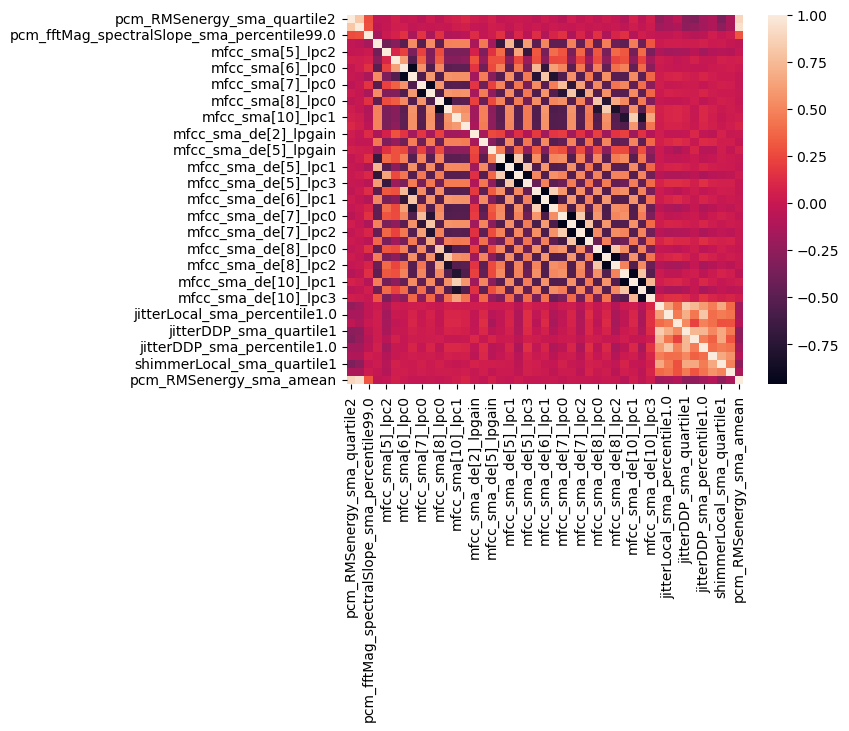

In [33]:
corr_feats_bf = bruteforce_df[(bruteforce_df.iloc[:,-1] > 0.60)].iloc[:,0].to_list()
corr_feats_idx_bf = train_df.columns.intersection(corr_feats_bf)
corr_df_bf = train_df[corr_feats_idx_bf].corr()
sns.heatmap(corr_df_bf)

## LR on held out test data

<---- Train and Test Accuracy ---->

Logistic accuracy train = 92.743
Logistic accuracy test = 93.281

<---- Classification Report ---->

              precision    recall  f1-score   support

           0       0.93      0.94      0.93       640
           1       0.94      0.93      0.93       640

    accuracy                           0.93      1280
   macro avg       0.93      0.93      0.93      1280
weighted avg       0.93      0.93      0.93      1280


<---- Confusion Matrix ---->



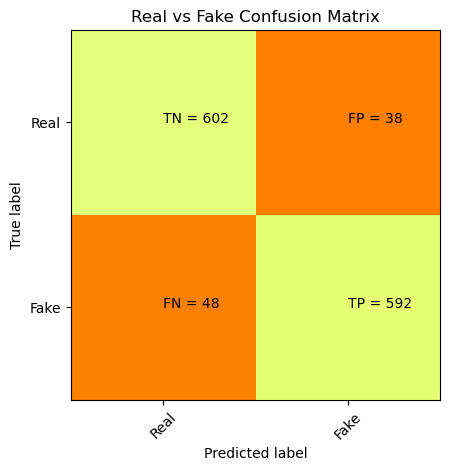


<---- ROC-AUC ---->

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.974



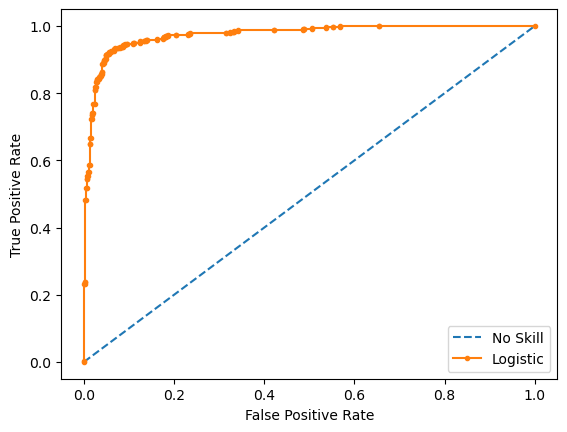

In [34]:
#pick features selected by brute force
feature_index = train_df.columns.intersection(selected_features_bf)
#Logistic Regression Model
model_lr_bf = LogisticRegression(max_iter=1000)
#run model
run_model_on_test_data(model_lr_bf, X_train_final, X_test, y_train_final, y_test, feature_index)

## SVM on held out test data

<---- Train and Test Accuracy ---->

Logistic accuracy train = 95.113
Logistic accuracy test = 92.891

<---- Classification Report ---->

              precision    recall  f1-score   support

           0       0.92      0.94      0.93       640
           1       0.94      0.92      0.93       640

    accuracy                           0.93      1280
   macro avg       0.93      0.93      0.93      1280
weighted avg       0.93      0.93      0.93      1280


<---- Confusion Matrix ---->



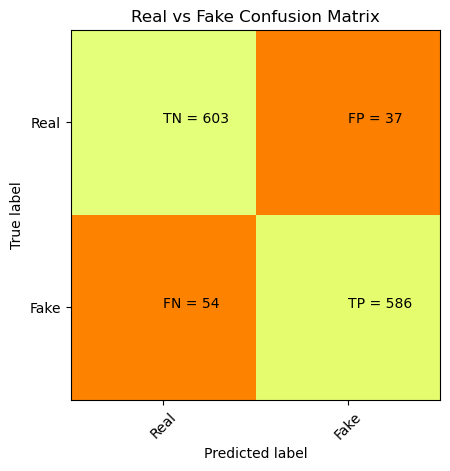


<---- ROC-AUC ---->

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.980



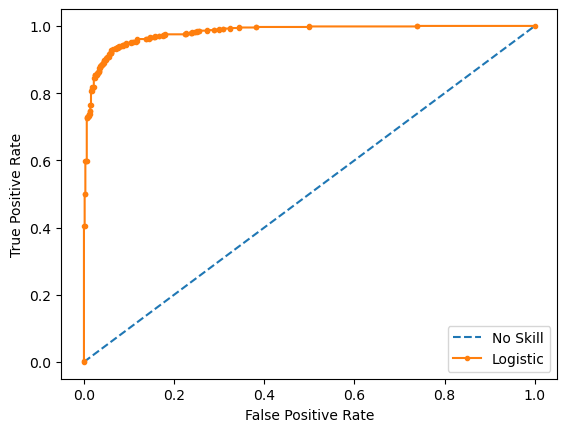

In [35]:
#pick features selected by brute force
feature_index_bf = train_df.columns.intersection(selected_features_bf)
#Logistic Regression Model
model_svm_bf = svm.SVC(probability=True)
#run model
run_model_on_test_data(model_svm_bf, X_train_final, X_test, y_train_final, y_test, feature_index_bf)

# Experiment 2: Feature Selection using SelectFromModel

## Model for Feature Selection - Random Forest Classifier(Feature Importance)

(hyperparameters selected based on a random search run in another notebook)

In [36]:
#hyperparameter selection 
n_estimators = 250 #default=100
criterion = "entropy" #{“gini”, “entropy”, “log_loss”}, default=”gini”
max_depth = 25 #default=None 
min_samples_split = 50 #default=2 The minimum number of samples required to split an internal node
min_samples_leaf = 10 #default=1 The minimum number of samples required to be at a leaf node.
max_features = "sqrt" #default="sqrt" The number of features to consider when looking for the best split:
bootstrap = True #default = True Whether bootstrap samples are used when building trees.
n_jobs = -1 #default=None -1 means all processors

In [37]:
#define model
"""model_rfc = RandomForestClassifier(n_estimators=n_estimators,
                                    max_depth=max_depth,
                                    criterion=criterion,
                                    max_features=max_features,
                                    bootstrap=bootstrap,
                                    min_samples_split=min_samples_split,
                                    min_samples_leaf=min_samples_leaf,
                                    n_jobs=n_jobs)"""

                            
model_rfc = RandomForestClassifier()
#fit model
model_rfc.fit(X_train, y_train)

#get feature importance 
importance = model_rfc.feature_importances_

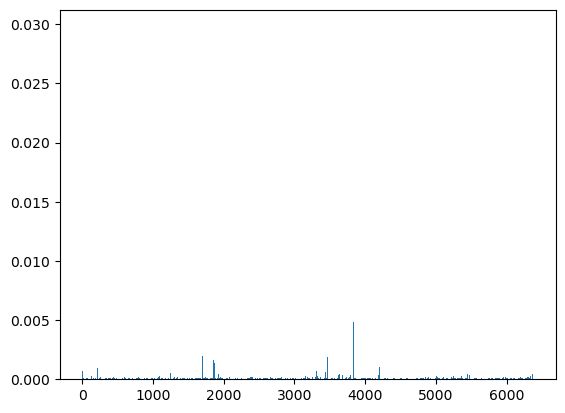

In [38]:
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [39]:
#accuracy on dev set
y_hat_rf_train = model_rfc.predict(X_train)
y_hat_rf_dev = model_rfc.predict(X_dev)
accuracy_rf_train = accuracy_score(y_train, y_hat_rf_train)
accuracy_rf_dev = accuracy_score(y_dev, y_hat_rf_dev)
print("Training accuracy: %0.2f" % (accuracy_rf_train))
print("Dev accuracy: %0.2f" % (accuracy_rf_dev))

Training accuracy: 1.00
Dev accuracy: 0.89


## Important Features

In [40]:
important_features_dict = {}
features = train_df.drop(columns=['id', 'file', 'type', 'duration(seconds)', 'fake']).columns

for idx, val in enumerate(importance):
    important_features_dict[idx] = val

important_features_list_sorted = sorted(important_features_dict,
                                         key=important_features_dict.get,
                                         reverse=True)

for i, feat_idx in enumerate(important_features_list_sorted[:100]):    
    print("%i) Feature: %s, Score: %.5f" % (i+1, features[feat_idx], important_features_dict[feat_idx]))

1) Feature: jitterDDP_sma_quartile1, Score: 0.02973
2) Feature: jitterDDP_sma_percentile1.0, Score: 0.02577
3) Feature: jitterDDP_sma_flatness, Score: 0.01806
4) Feature: jitterLocal_sma_percentile1.0, Score: 0.01333
5) Feature: jitterDDP_sma_quartile2, Score: 0.00811
6) Feature: mfcc_sma[7]_lpc0, Score: 0.00749
7) Feature: jitterLocal_sma_quartile1, Score: 0.00603
8) Feature: shimmerLocal_sma_quartile1, Score: 0.00598
9) Feature: mfcc_sma_de[5]_lpc0, Score: 0.00548
10) Feature: shimmerLocal_sma_percentile1.0, Score: 0.00488
11) Feature: mfcc_sma_de[10]_lpc1, Score: 0.00474
12) Feature: mfcc_sma[12]_lpgain, Score: 0.00440
13) Feature: jitterLocal_sma_flatness, Score: 0.00434
14) Feature: mfcc_sma[10]_lpc0, Score: 0.00420
15) Feature: mfcc_sma[6]_lpc0, Score: 0.00398
16) Feature: mfcc_sma_de[6]_lpc2, Score: 0.00368
17) Feature: mfcc_sma[12]_lpc1, Score: 0.00345
18) Feature: mfcc_sma_de[6]_lpc0, Score: 0.00344
19) Feature: mfcc_sma_de[6]_lpc1, Score: 0.00328
20) Feature: mfcc_sma_de[3]_l

In [41]:
# feature selection
def select_features(model, X_train, y_train, X_test, max_features=50):
	# configure to select a subset of features
	fs = SelectFromModel(model, max_features=max_features)
	# learn relationship from training data
	fs.fit(X_train, y_train)
	# transform train input data
	X_train_fs = fs.transform(X_train)
	# transform test input data
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs

In [42]:
# feature selection
X_train_fs, X_dev_fs, fs = select_features(model_rfc, X_train, y_train, X_dev)

In [43]:
fidx = fs.get_support()
features[fidx]

Index(['pcm_zcr_sma_range', 'pcm_zcr_sma_quartile1',
       'pcm_zcr_sma_percentile1.0', 'pcm_zcr_sma_de_percentile1.0',
       'pcm_fftMag_spectralFlux_sma_stddev', 'mfcc_sma[3]_lpc1',
       'mfcc_sma[5]_lpc0', 'mfcc_sma[5]_lpc1', 'mfcc_sma[6]_lpc0',
       'mfcc_sma[6]_lpc1', 'mfcc_sma[7]_lpc0', 'mfcc_sma[7]_lpc1',
       'mfcc_sma[8]_lpc0', 'mfcc_sma[9]_lpc0', 'mfcc_sma[9]_lpc1',
       'mfcc_sma[10]_lpc0', 'mfcc_sma[10]_lpc1', 'mfcc_sma[11]_lpc0',
       'mfcc_sma[11]_lpc1', 'mfcc_sma[12]_lpgain', 'mfcc_sma[12]_lpc1',
       'mfcc_sma[13]_lpgain', 'mfcc_sma_de[2]_lpc1', 'mfcc_sma_de[3]_lpc2',
       'mfcc_sma_de[5]_lpc1', 'mfcc_sma_de[5]_lpc2', 'mfcc_sma_de[6]_lpc0',
       'mfcc_sma_de[6]_lpc3', 'mfcc_sma_de[7]_lpc0', 'mfcc_sma_de[8]_lpgain',
       'mfcc_sma_de[8]_lpc1', 'mfcc_sma_de[9]_lpgain', 'mfcc_sma_de[9]_lpc0',
       'mfcc_sma_de[9]_lpc2', 'mfcc_sma_de[10]_lpc1', 'mfcc_sma_de[10]_lpc2',
       'mfcc_sma_de[11]_lpc0', 'mfcc_sma_de[11]_lpc2',
       'jitterLocal_sma_flatne

In [44]:
corr_feats = fs.get_feature_names_out()
corr_feats_index = train_df.columns.intersection(corr_feats)
train_df_corr = train_df[corr_feats_index].corr()

<AxesSubplot: >

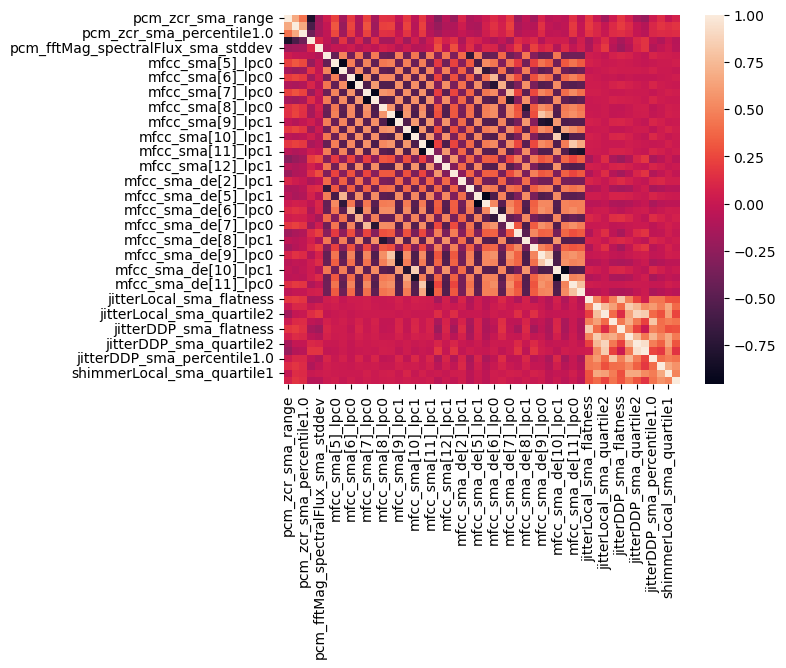

In [45]:
sns.heatmap(train_df_corr)

## Selecting optimal features and model

In [46]:
cellEnabled = 0
#cellEnabled = 1

#select max features
max_features = np.arange(5,100,1)

if cellEnabled:

    lr_accuracies_train = []
    lr_accuracies_dev = []

    knnc_accuracies_train = []
    knnc_accuracies_dev = []

    svm_accuracies_train = []
    svm_accuracies_dev = []
    
    for i in tqdm(range(len(max_features))):

        X_train_fs, X_dev_fs, fs = select_features(model_rfc, X_train, y_train, X_dev, max_features[i])

        # fit the logreg model
        model_lr = LogisticRegression(max_iter=1000)
        model_lr.fit(X_train_fs, y_train)
        # evaluate the model
        yhat_lr_train = model_lr.predict(X_train_fs)
        yhat_lr_dev = model_lr.predict(X_dev_fs)
        # evaluate predictions
        lr_accuracies_train.append(accuracy_score(y_train, yhat_lr_train))
        lr_accuracies_dev.append(accuracy_score(y_dev, yhat_lr_dev))

        #KNN classifier
        model_knnc = KNeighborsClassifier()
        model_knnc.fit(X_train_fs, y_train)
        # evaluate the model
        yhat_knnc_train = model_knnc.predict(X_train_fs)
        yhat_knnc_dev = model_knnc.predict(X_dev_fs)
        # evaluate predictions
        knnc_accuracies_train.append(accuracy_score(y_train, yhat_knnc_train))
        knnc_accuracies_dev.append(accuracy_score(y_dev, yhat_knnc_dev))

        #SVM classifier
        #rbf SVM
        model_svm = svm.SVC()
        #fit the model 
        model_svm.fit(X_train_fs, y_train)
        # evaluate the model
        yhat_svm_train = model_svm.predict(X_train_fs)
        yhat_svm_dev = model_svm.predict(X_dev_fs)
        # evaluate predictions
        svm_accuracies_train.append(accuracy_score(y_train, yhat_svm_train))
        svm_accuracies_dev.append(accuracy_score(y_dev, yhat_svm_dev))

In [47]:
cellEnabled = 0
#cellEnabled = 1

savefile = base_path + 'testing-code/opensmile-feature-importance/smile_dfs/run_data/' + '0311-exp2_run_data.csv'

if cellEnabled:
    exp2_data = pd.DataFrame()
    exp2_data['lr_accuracies_train'] = lr_accuracies_train[:-1]
    exp2_data['lr_accuracies_dev'] = lr_accuracies_dev[:-1]
    exp2_data['knnc_accuracies_train'] = knnc_accuracies_train[:-1]
    exp2_data['knnc_accuracies_dev'] = knnc_accuracies_dev[:-1]
    exp2_data['svm_accuracies_train'] = svm_accuracies_train
    exp2_data['svm_accuracies_dev'] = svm_accuracies_dev
    
    exp2_data.to_csv(savefile, index=False)
    
exp2_data = pd.read_csv(savefile)

lr_accuracies_train = exp2_data['lr_accuracies_train'].to_list()
lr_accuracies_dev = exp2_data['lr_accuracies_dev'].to_list()

knnc_accuracies_train = exp2_data['knnc_accuracies_train'].to_list()
knnc_accuracies_dev = exp2_data['knnc_accuracies_dev'].to_list()

svm_accuracies_train = exp2_data['svm_accuracies_train'].to_list()
svm_accuracies_dev = exp2_data['svm_accuracies_dev'].to_list()

In [48]:
len(lr_accuracies_train), len(knnc_accuracies_train), len(svm_accuracies_train)

(95, 95, 95)

In [49]:
len(lr_accuracies_dev), len(knnc_accuracies_dev), len(svm_accuracies_dev)

(95, 95, 95)

__Train accuracy plot__

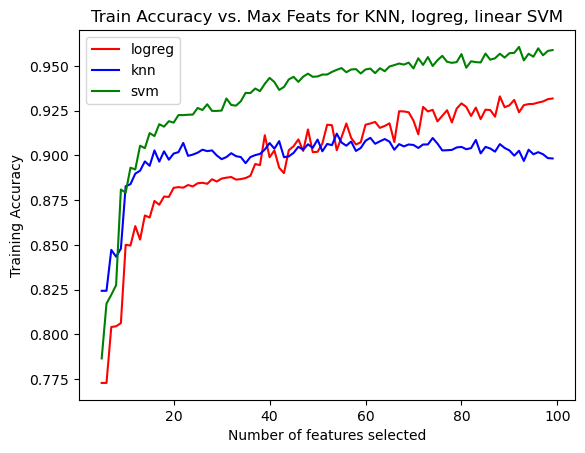

In [50]:
sns.lineplot(x=max_features, y=lr_accuracies_train, color='red', label='logreg')
sns.lineplot(x=max_features, y=knnc_accuracies_train, color='blue', label='knn')
sns.lineplot(x=max_features, y=svm_accuracies_train, color='green', label='svm')
plt.title('Train Accuracy vs. Max Feats for KNN, logreg, linear SVM')
plt.xlabel('Number of features selected')
plt.ylabel('Training Accuracy')
plt.show()

__Dev Accuracy Plot__

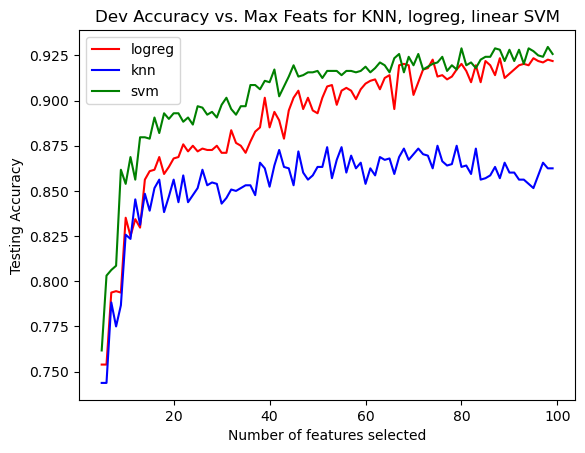

In [51]:
sns.lineplot(x=max_features, y=lr_accuracies_dev, color='red', label='logreg')
sns.lineplot(x=max_features, y=knnc_accuracies_dev, color='blue', label='knn')
sns.lineplot(x=max_features, y=svm_accuracies_dev, color='green', label='svm')
plt.title('Dev Accuracy vs. Max Feats for KNN, logreg, linear SVM')
plt.xlabel('Number of features selected')
plt.ylabel('Testing Accuracy')
plt.show()

## SVM Model With 40 features on held out test data:

In [52]:
X_train_fs_e2, X_test_fs_e2, fs = select_features(model_rfc, X_train_final, y_train_final, X_test, 40)

In [53]:
X_train_fs, X_test_fs, fs = select_features(model_rfc, X_train_final, y_train_final, X_test, 40)

#SVM classifier
model_svm = svm.SVC(probability=True)
model_svm.fit(X_train_fs, y_train_final)

# evaluate the model
yhat_svm_train = model_svm.predict(X_train_fs)
yhat_svm_test = model_svm.predict(X_test_fs)

#compute accuracy
accuracy_svm_train = accuracy_score(y_train_final, yhat_svm_train)
accuracy_svm_test = accuracy_score(y_test, yhat_svm_test)

#print
print('SVM accuracy train = %.3f' % (accuracy_svm_train*100))
print('SVM accuracy test = %.3f' % (accuracy_svm_test*100))

SVM accuracy train = 94.444
SVM accuracy test = 92.188


## Experiment 2 selected features:

In [54]:
exp_2_feature_set = set(fs.get_feature_names_out())

In [55]:
exp_2_feature_set

{'jitterDDP_sma_flatness',
 'jitterDDP_sma_percentile1.0',
 'jitterDDP_sma_quartile1',
 'jitterDDP_sma_quartile2',
 'jitterLocal_sma_flatness',
 'jitterLocal_sma_percentile1.0',
 'jitterLocal_sma_quartile1',
 'mfcc_sma[10]_lpc0',
 'mfcc_sma[11]_lpc0',
 'mfcc_sma[11]_lpgain',
 'mfcc_sma[12]_lpc1',
 'mfcc_sma[14]_lpc1',
 'mfcc_sma[14]_lpgain',
 'mfcc_sma[6]_lpc0',
 'mfcc_sma[6]_lpc1',
 'mfcc_sma[7]_lpc1',
 'mfcc_sma[9]_lpc0',
 'mfcc_sma[9]_lpc1',
 'mfcc_sma_de[10]_lpc0',
 'mfcc_sma_de[10]_lpc1',
 'mfcc_sma_de[12]_lpc1',
 'mfcc_sma_de[13]_lpc1',
 'mfcc_sma_de[14]_lpgain',
 'mfcc_sma_de[3]_lpc1',
 'mfcc_sma_de[5]_lpc2',
 'mfcc_sma_de[5]_lpgain',
 'mfcc_sma_de[6]_lpc0',
 'mfcc_sma_de[8]_lpc0',
 'mfcc_sma_de[8]_lpc1',
 'mfcc_sma_de[8]_lpc2',
 'mfcc_sma_de[9]_lpc0',
 'mfcc_sma_de[9]_lpc2',
 'pcm_fftMag_spectralFlux_sma_percentile99.0',
 'pcm_zcr_sma_percentile1.0',
 'pcm_zcr_sma_quartile1',
 'pcm_zcr_sma_quartile2',
 'pcm_zcr_sma_range',
 'shimmerLocal_sma_flatness',
 'shimmerLocal_sma_percen

# Experiment 3: Feature Selection using SelectKBest

In [56]:
cellEnabled = 0
#cellEnabled = 1

savefile_e3 = base_path + 'testing-code/opensmile-feature-importance/smile_dfs/run_data/' + '0311-exp3_feats.txt'

if cellEnabled:

    #fit selector 
    e3_selector = SelectKBest(mutual_info_regression, k=100)
    e3_selector.fit(X_train, y_train)
    
    selected_feats_e3 = e3_selector.get_feature_names_out()
    np.savetxt(savefile_e3, selected_feats_e3, fmt='%s')

if not cellEnabled:
    selected_feats_e3 = np.genfromtxt(savefile_e3 ,dtype='str')

In [57]:
exp_3_feature_set = set(selected_feats_e3)

## SVM model with selected features

In [58]:
#select features identified from brute force
feature_index_e3 = train_df.columns.intersection(selected_feats_e3)

#SVM classifier
model_svm_e3 = svm.SVC(probability=True)
model_svm_e3.fit(X_train_final[feature_index_e3], y_train_final)

# evaluate the model
yhat_svme3_train = model_svm_e3.predict(X_train_final[feature_index_e3])
yhat_svme3_test = model_svm_e3.predict(X_test[feature_index_e3])

#compute accuracy
accuracy_svme3_train = accuracy_score(y_train_final, yhat_svme3_train)
accuracy_svme3_test = accuracy_score(y_test, yhat_svme3_test)

#print
print('SVM accuracy train = %.3f' % (accuracy_svme3_train*100))
print('SVM accuracy test = %.3f' % (accuracy_svme3_test*100))

SVM accuracy train = 95.043
SVM accuracy test = 91.250


# Experiment 4: Running Forward selection 

- on the 100 Features Selected in Experiment 3

In [59]:
cellEnabled = 0
#cellEnabled = 1

savefile_e4 = base_path + 'testing-code/opensmile-feature-importance/smile_dfs/run_data/' + '0312-exp4_feats.txt'

if cellEnabled:
    
    sfs_selector_e4 = SequentialFeatureSelector(estimator=svm.SVC(),
                                                 n_features_to_select=15,
                                                 cv=5,
                                                 direction='forward')

    #select features identified from brute force
    feature_index_e3 = train_df.columns.intersection(selected_feats_e3)

    sfs_selector_e4.fit(X_train_final[feature_index_e3], y_train_final)
    
    selected_feats_e4 = sfs_selector_e4.get_feature_names_out()
    np.savetxt(savefile_e4, selected_feats_e4, fmt='%s')

if not cellEnabled:
    selected_feats_e4 = np.genfromtxt(savefile_e4, dtype='str')

In [60]:
selected_feats_e4

array(['pcm_zcr_sma_range', 'mfcc_sma[6]_lpc0', 'mfcc_sma[6]_lpc1',
       'mfcc_sma_de[5]_lpc2', 'mfcc_sma_de[6]_lpgain',
       'mfcc_sma_de[8]_lpc2', 'mfcc_sma_de[9]_lpgain',
       'mfcc_sma_de[9]_lpc2', 'mfcc_sma_de[13]_lpgain',
       'mfcc_sma_de[14]_lpgain', 'jitterLocal_sma_quartile1',
       'jitterDDP_sma_flatness', 'jitterDDP_sma_quartile1',
       'jitterDDP_sma_percentile1.0', 'audspec_lengthL1norm_sma_amean'],
      dtype='<U30')

## Running SVM

In [61]:
#select features identified from brute force
feature_index_e4 = train_df.columns.intersection(selected_feats_e4)

#SVM classifier
model_svm_e4 = svm.SVC(probability=True)
model_svm_e4.fit(X_train_final[feature_index_e4], y_train_final)

# evaluate the model
yhat_svme4_train = model_svm_e4.predict(X_train_final[feature_index_e4])
yhat_svme4_test = model_svm_e4.predict(X_test[feature_index_e4])

#compute accuracy
accuracy_svme4_train = accuracy_score(y_train_final, yhat_svme4_train)
accuracy_svme4_test = accuracy_score(y_test, yhat_svme4_test)

#print
print('SVM accuracy train = %.3f' % (accuracy_svme4_train*100))
print('SVM accuracy test = %.3f' % (accuracy_svme4_test*100))

SVM accuracy train = 92.752
SVM accuracy test = 91.562


# Experiment 5: Hand selecting features and ablations

This set of experiments show us that the MFCC features combined with Jitter and Shimmer are the best set of features for the SVM classification model.

In [62]:
#get a list of all features for analysis
all_feats = train_df.columns[5:]
len(all_feats)

6373

#### Exp 5(a): All MFCC features 

In [63]:
mfcc_feats = [feat for feat in all_feats if 'mfcc' in feat and 'lp' in feat]
len(mfcc_feats)

168

In [64]:
#select features identified from brute force
feature_index_e5a = train_df.columns.intersection(mfcc_feats)

#SVM classifier
model_svm_e5a = svm.SVC(probability=True)
model_svm_e5a.fit(X_train_final[feature_index_e5a], y_train_final)

# evaluate the model
yhat_svme5a_train = model_svm_e5a.predict(X_train_final[feature_index_e5a])
yhat_svme5a_test = model_svm_e5a.predict(X_test[feature_index_e5a])

#compute accuracy
accuracy_svme5a_train = accuracy_score(y_train_final, yhat_svme5a_train)
accuracy_svme5a_test = accuracy_score(y_test, yhat_svme5a_test)

#print
print('SVM accuracy train = %.3f' % (accuracy_svme5a_train*100))
print('SVM accuracy test = %.3f' % (accuracy_svme5a_test*100))

SVM accuracy train = 86.398
SVM accuracy test = 79.609


#### Exp 5(b): No derivative MFCC features 

In [65]:
mfcc_feats_2 = [feat for feat in all_feats if 'mfcc' in feat and 'lp' in feat and 'de' not in feat]
len(mfcc_feats_2)

84

In [66]:
#select features identified from brute force
feature_index_e5b = train_df.columns.intersection(mfcc_feats_2)

#SVM classifier
model_svm_e5b = svm.SVC(probability=True)
model_svm_e5b.fit(X_train_final[feature_index_e5b], y_train_final)

# evaluate the model
yhat_svme5b_train = model_svm_e5b.predict(X_train_final[feature_index_e5b])
yhat_svme5b_test = model_svm_e5b.predict(X_test[feature_index_e5b])

#compute accuracy
accuracy_svme5b_train = accuracy_score(y_train_final, yhat_svme5b_train)
accuracy_svme5b_test = accuracy_score(y_test, yhat_svme5b_test)

#print
print('SVM accuracy train = %.3f' % (accuracy_svme5b_train*100))
print('SVM accuracy test = %.3f' % (accuracy_svme5b_test*100))

SVM accuracy train = 84.505
SVM accuracy test = 78.828


#### Exp 5(c): Only derivative MFCC features 

In [67]:
mfcc_feats_3 = [feat for feat in all_feats if 'mfcc' in feat and 'lp' in feat and 'de' in feat]
len(mfcc_feats_3)

84

In [68]:
#select features identified from brute force
feature_index_e5c = train_df.columns.intersection(mfcc_feats_3)

#SVM classifier
model_svm_e5c = svm.SVC(probability=True)
model_svm_e5c.fit(X_train_final[feature_index_e5c], y_train_final)

# evaluate the model
yhat_svme5c_train = model_svm_e5c.predict(X_train_final[feature_index_e5c])
yhat_svme5c_test = model_svm_e5c.predict(X_test[feature_index_e5c])

#compute accuracy
accuracy_svme5c_train = accuracy_score(y_train_final, yhat_svme5c_train)
accuracy_svme5c_test = accuracy_score(y_test, yhat_svme5c_test)

#print
print('SVM accuracy train = %.3f' % (accuracy_svme5c_train*100))
print('SVM accuracy test = %.3f' % (accuracy_svme5c_test*100))

SVM accuracy train = 83.325
SVM accuracy test = 76.406


#### Exp 5(d): Feature selected MFCC features

In [69]:
#corr feats comes from experiment 2
mfcc_feats_4 = [feat for feat in all_feats if 'mfcc' in feat and feat in corr_feats]
len(mfcc_feats_4)

33

In [70]:
#select features identified from brute force
feature_index_e5d = train_df.columns.intersection(mfcc_feats_4)

#SVM classifier
model_svm_e5d = svm.SVC(probability=True)
model_svm_e5d.fit(X_train_final[feature_index_e5d], y_train_final)

# evaluate the model
yhat_svme5d_train = model_svm_e5d.predict(X_train_final[feature_index_e5d])
yhat_svme5d_test = model_svm_e5d.predict(X_test[feature_index_e5d])

#compute accuracy
accuracy_svme5d_train = accuracy_score(y_train_final, yhat_svme5d_train)
accuracy_svme5d_test = accuracy_score(y_test, yhat_svme5d_test)

#print
print('SVM accuracy train = %.3f' % (accuracy_svme5d_train*100))
print('SVM accuracy test = %.3f' % (accuracy_svme5d_test*100))

SVM accuracy train = 77.049
SVM accuracy test = 74.297


#### Exp 5(e): Jitter and Shimmer Features Alone

In [71]:
jshm_feats = [feat for feat in all_feats if ('jitter' in feat or 'shimmer' in feat) and ('flatness' in feat or 'percentle' in feat or 'quartile' in feat)]
len(jshm_feats)

24

In [72]:
#select features identified from brute force
feature_index_e5e = train_df.columns.intersection(jshm_feats)

#SVM classifier
model_svm_e5e = svm.SVC(probability=True)
model_svm_e5e.fit(X_train_final[feature_index_e5e], y_train_final)

# evaluate the model
yhat_svme5e_train = model_svm_e5e.predict(X_train_final[feature_index_e5e])
yhat_svme5e_test = model_svm_e5e.predict(X_test[feature_index_e5e])

#compute accuracy
accuracy_svme5e_train = accuracy_score(y_train_final, yhat_svme5e_train)
accuracy_svme5e_test = accuracy_score(y_test, yhat_svme5e_test)

#print
print('SVM accuracy train = %.3f' % (accuracy_svme5e_train*100))
print('SVM accuracy test = %.3f' % (accuracy_svme5e_test*100))

SVM accuracy train = 85.208
SVM accuracy test = 83.516


#### Exp 5(f): Jitter and Shimmer Features + MFCC Features

In [73]:
mj_feats = mfcc_feats + jshm_feats
len(mj_feats)

192

In [74]:
#select features identified from brute force
feature_index_e5f = train_df.columns.intersection(mj_feats)

#SVM classifier
model_svm_e5f = svm.SVC(probability=True)
model_svm_e5f.fit(X_train_final[feature_index_e5f], y_train_final)

# evaluate the model
yhat_svme5f_train = model_svm_e5f.predict(X_train_final[feature_index_e5f])
yhat_svme5f_test = model_svm_e5f.predict(X_test[feature_index_e5f])

#compute accuracy
accuracy_svme5f_train = accuracy_score(y_train_final, yhat_svme5f_train)
accuracy_svme5f_test = accuracy_score(y_test, yhat_svme5f_test)

#print
print('SVM accuracy train = %.3f' % (accuracy_svme5f_train*100))
print('SVM accuracy test = %.3f' % (accuracy_svme5f_test*100))

SVM accuracy train = 96.102
SVM accuracy test = 91.562


#### Exp 5(g): Other features

In [75]:
fez_feats = [feat for feat in all_feats if ('Entropy' in feat or 'Flux' in feat or 'zcr' in feat) and ('range' in feat or 'lpc' in feat or 'Slope' in feat)]
len(fez_feats)

66

In [76]:
#select features identified from brute force
feature_index_e5g = train_df.columns.intersection(fez_feats)

#SVM classifier
model_svm_e5g = svm.SVC(probability=True)
model_svm_e5g.fit(X_train_final[feature_index_e5g], y_train_final)

# evaluate the model
yhat_svme5g_train = model_svm_e5g.predict(X_train_final[feature_index_e5g])
yhat_svme5g_test = model_svm_e5g.predict(X_test[feature_index_e5g])

#compute accuracy
accuracy_svme5g_train = accuracy_score(y_train_final, yhat_svme5g_train)
accuracy_svme5g_test = accuracy_score(y_test, yhat_svme5g_test)

#print
print('SVM accuracy train = %.3f' % (accuracy_svme5g_train*100))
print('SVM accuracy test = %.3f' % (accuracy_svme5g_test*100))

SVM accuracy train = 75.738
SVM accuracy test = 71.016


#### Exp 5(h): All feats cnsidered so far

In [77]:
mjo_feats = mfcc_feats + jshm_feats + fez_feats
len(mjo_feats)

258

In [78]:
#select features identified from brute force
feature_index_e5h = train_df.columns.intersection(mfcc_feats_3)

#SVM classifier
model_svm_e5h = svm.SVC(probability=True)
model_svm_e5h.fit(X_train_final[feature_index_e5h], y_train_final)

# evaluate the model
yhat_svme5h_train = model_svm_e5h.predict(X_train_final[feature_index_e5h])
yhat_svme5h_test = model_svm_e5h.predict(X_test[feature_index_e5h])

#compute accuracy
accuracy_svme5h_train = accuracy_score(y_train_final, yhat_svme5h_train)
accuracy_svme5h_test = accuracy_score(y_test, yhat_svme5h_test)

#print
print('SVM accuracy train = %.3f' % (accuracy_svme5h_train*100))
print('SVM accuracy test = %.3f' % (accuracy_svme5h_test*100))

SVM accuracy train = 83.325
SVM accuracy test = 76.406


# Run on Final Feature Set from all experiments

In [79]:
all_exp_feats = set.union(exp_1_feature_set, exp_2_feature_set, exp_3_feature_set)
len(all_exp_feats)

126

In [80]:
#select features identified from brute force
feature_index_e6 = train_df.columns.intersection(all_exp_feats)

#SVM classifier
model_svm_e6 = svm.SVC(probability=True)
model_svm_e6.fit(X_train_final[feature_index_e6], y_train_final)

# evaluate the model
yhat_svme6_train = model_svm_e6.predict(X_train_final[feature_index_e6])
yhat_svme6_test = model_svm_e6.predict(X_test[feature_index_e6])

#compute accuracy
accuracy_svme6_train = accuracy_score(y_train_final, yhat_svme6_train)
accuracy_svme6_test = accuracy_score(y_test, yhat_svme6_test)

#print
print('SVM accuracy train = %.3f' % (accuracy_svme6_train*100))
print('SVM accuracy test = %.3f' % (accuracy_svme6_test*100))

SVM accuracy train = 95.807
SVM accuracy test = 94.141


In [81]:
print(classification_report(y_test, yhat_svme6_test))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       640
           1       0.95      0.93      0.94       640

    accuracy                           0.94      1280
   macro avg       0.94      0.94      0.94      1280
weighted avg       0.94      0.94      0.94      1280



In [82]:
# defining parameter range
param_grid = {'C': [0.1, 0.5, 1, 5, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 

  
grid = GridSearchCV(svm.SVC(), param_grid, refit = True, verbose = 3)
  
# fitting the model for grid search
grid.fit(X_train_final[feature_index_e6], y_train_final)

Fitting 5 folds for each of 35 candidates, totalling 175 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.501 total time=   9.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.500 total time=   9.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.501 total time=   9.3s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.500 total time=   9.1s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.500 total time=   9.5s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.524 total time=   9.2s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.618 total time=  10.0s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.549 total time=   8.8s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.564 total time=   8.7s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.544 total time=   8.9s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.899 total time=   3.9s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 0.5, 1, 5, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [83]:
grid.best_estimator_

SVC(C=100, gamma=0.001)

In [84]:
#select features identified from brute force
feature_index_e6 = train_df.columns.intersection(all_exp_feats)

#SVM classifier
model_svm_e6 = svm.SVC(C=1000, gamma=0.0001, probability=True)
model_svm_e6.fit(X_train_final[feature_index_e6], y_train_final)

# evaluate the model
yhat_svme6_train = model_svm_e6.predict(X_train_final[feature_index_e6])
yhat_svme6_test = model_svm_e6.predict(X_test[feature_index_e6])

#compute accuracy
accuracy_svme6_train = accuracy_score(y_train_final, yhat_svme6_train)
accuracy_svme6_test = accuracy_score(y_test, yhat_svme6_test)

#print
print('SVM accuracy train = %.3f' % (accuracy_svme6_train*100))
print('SVM accuracy test = %.3f' % (accuracy_svme6_test*100))

SVM accuracy train = 94.670
SVM accuracy test = 93.906
